# Extraction d'informations
L'entrée est le fichier JSON `diderot_1751_wd` contenant les QID. Pour tout QID, le programme extrait les types wikidata, les libellés, titres et positions géographiques si ces informations existent. On fusionne les informations pour chaque QID.

On extrait les coordonnées car on suppose que la majorité des références seront des lieux. On extrait aussi les dates de naissance et de décès quand elles existent.

__auteur__: Pierre Nugues

In [1]:
import regex as re
import bs4
import requests
import sys
import os
import pickle
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict
import time
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from collections import Counter
import json

In [2]:
TEMPO = 1
MAX_ESSAIS = 5

In [3]:
with open('diderot_1751_wd.json', 'r') as f:
    diderot_wd = json.loads(f.read())

In [4]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'

In [5]:
prefixes = '''PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>'''

In [6]:
headers = {
    'User-Agent': 'NLP-project/1.0 (pierre.nugues@cs.lth.se)'
}

## Structure les articles. Quelques exemples

In [7]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [8]:
diderot_wd[:3]

[{'vedette': 'A',
  'entreeid': 'v1-9-0',
  'texte': '*\u200b A, s. petite riviere de France, qui a sa source près de Fontaines en Sologne.',
  'qid': ['Q15803785'],
  'note': 'https://fr.wikisource.org/wiki/Page:Trevoux_-_Dictionnaire,_1743,_T01,_A.djvu/32'},
 {'vedette': 'AA',
  'entreeid': 'v1-10-0',
  'texte': '*\u200b AA, s. f. riviere de France, qui prend sa source dans le haut Boulonnois, sépare la Flandre de la Picardie, & se jette dans l’Océan au-dessous de Gravelines. Il y a trois rivieres de ce nom dans le Pays bas, trois en Suisse, & cinq en Westphalie.',
  'qid': ['Q300661']},
 {'vedette': 'AACH ou ACH',
  'entreeid': 'v1-12-0',
  'texte': '*\u200b AACH ou ACH, s. f. petite ville d’Allemagne dans le cercle de Souabe, près de la source de l’Aach. Long. 26. 57. lat. 47. 55.',
  'qid': ['Q62158'],
  'note': ''}]

In [9]:
diderot_wd[200]

{'vedette': 'ALBE-JULIE ou WEISSEMBOURG',
 'entreeid': 'v1-1061-0',
 'texte': '*\u200b ALBE-JULIE ou WEISSEMBOURG, (Géog.)\u200b ville de Transylvanie, près des rivieres d’Ompay & de Mérish. Long. 42. lat. 46. 30.',
 'qid': ['Q174665']}

In [10]:
diderot_wd[1]

{'vedette': 'AA',
 'entreeid': 'v1-10-0',
 'texte': '*\u200b AA, s. f. riviere de France, qui prend sa source dans le haut Boulonnois, sépare la Flandre de la Picardie, & se jette dans l’Océan au-dessous de Gravelines. Il y a trois rivieres de ce nom dans le Pays bas, trois en Suisse, & cinq en Westphalie.',
 'qid': ['Q300661']}

## Requête

In [11]:
def applique_requete(qt, prefixes, headers):
    try:
        data = requests.get(
            url, params={
                'query': prefixes + qt, 
                'format': 'json', 
                'headers': headers}).json()
        data = data['results']['bindings']
    except:
        data = ['échec']
    return data

## Un exemple
Jean-Pierre Moret de Bourchenu `Q3169582`

In [12]:
qt_test = """SELECT ?type ?occs
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0}  p:P106 ?occupation .
            ?occupation ps:P106 ?occs .
        }}
    }}""".format('Q3169582')

In [13]:
qt_test

'SELECT ?type ?occs\n    WHERE \n    {\n        OPTIONAL {\n            wd:Q3169582  wdt:P31 ?type .\n        }\n        OPTIONAL {\n            wd:Q3169582  p:P106 ?occupation .\n            ?occupation ps:P106 ?occs .\n        }\n    }'

In [14]:
applique_requete(qt_test, prefixes, headers)

[{'occs': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q201788'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'}}]

On crée une requête qui ratisse large. On devrait en faire deux avec:
* si ville -> coordonnées et 
* si humain -> date de naissance et occupations

In [15]:
def cree_requete(cand):
    query = '''
    SELECT ?type ?dn ?dd ?libellé_fr ?desc_fr ?libellé_en ?desc_en ?geo
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_fr filter (lang(?libellé_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_en filter (lang(?libellé_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_fr filter (lang(?desc_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_en filter (lang(?desc_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} wdt:P569 ?dn .
        }}
        OPTIONAL {{
            wd:{0} wdt:P570 ?dd .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P625 ?geo .
        }}
    }}'''.format(cand)
    return query

In [16]:
for idx, article in enumerate(diderot_wd):
    if 'qid' in article and len(article['qid']) > 1:
        print(idx)
        break

49


In [17]:
diderot_wd[49]

{'vedette': 'ABRUZZE',
 'entreeid': 'v1-201-0',
 'texte': '*\u200b ABRUZZE, s. f. Province du Royaume de Naples en Italie. Long. 30. 40. 32. 45. lat. 41. 45. 42. 52.',
 'qid': ['Q2821978', 'Q2821979']}

In [18]:
diderot_wd[217]

{'vedette': 'ALCANTARA',
 'entreeid': 'v1-1109-0',
 'texte': '*\u200b ALCANTARA, (Géog.)\u200b ville d’Espagne, dans l’Estramadure, sur le Tage. Long. 11. 35. lat. 39. 20. Il y a en Espagne une autre ville nommée Valencia d’Alcantara ; c’est encore le nom d’une contrée de Portugal, à une lieue ou environ au-dessous de Lisbonne.',
 'qid': ['Q389205', 'Q1613421', 'Q1017927'],
 'note': 'Bouillet, 796'}

In [19]:
qt = cree_requete('Q389205')
data = requests.get(url, params={
                    'query': prefixes + qt, 'format': 'json', 'headers': headers}).json()

In [20]:
data['results']['bindings']

[{'desc_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'municipality in the province of Cáceres, Spain'},
  'desc_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'commune espagnole'},
  'libellé_en': {'xml:lang': 'en', 'type': 'literal', 'value': 'Alcántara'},
  'libellé_fr': {'xml:lang': 'fr', 'type': 'literal', 'value': 'Alcántara'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q3957'},
  'geo': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral',
   'type': 'literal',
   'value': 'Point(-6.883888888 39.718611111)'}},
 {'desc_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'municipality in the province of Cáceres, Spain'},
  'desc_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'commune espagnole'},
  'libellé_en': {'xml:lang': 'en', 'type': 'literal', 'value': 'Alcántara'},
  'libellé_fr': {'xml:lang': 'fr', 'type': 'literal', 'value': 'Alcántara'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/e

## Fonctions de nettoyage
Wikidata retourne des dictionnaires avec des informations de type et autre. On enlève les clés verbeuses et on ne garde que `value`

In [21]:
def condense_dict(dico: dict) -> dict:
    nouv_dict = dict()
    for key in dico.keys():
        if type(dico[key]) == dict and 'value' in dico[key]:
            nouv_dict[key] = dico[key]['value']
        else:
            nouv_dict[key] = dico[key]
    return nouv_dict

Pour chaque QID, wikidata retourne une liste de dictionnaires avec des doublons. On rassemble les valeurs d'une clé dans une liste de dicos

In [22]:
def deduplique(dicos: list[dict]) -> dict:
    nouv_dict = dict()
    for dico in dicos:
        for key in dico.keys():
            if key in nouv_dict:
                nouv_dict[key] += [dico[key]]
            else:
                nouv_dict[key] = [dico[key]]
    for key in nouv_dict.keys():
        nouv_dict[key] = set(nouv_dict[key])
    for key in nouv_dict.keys():
        vals = []
        for val in nouv_dict[key]:
            if val.startswith('http://www.wikidata.org/entity/'):
                vals += [val[len('http://www.wikidata.org/entity/'):]]
            else:
                vals += [val]
        nouv_dict[key] = vals
    return nouv_dict

In [23]:
def fusionne_dicts_wd(dicts_wd: list) -> dict:
    dicts_cond = [condense_dict(dict_wd)
                  for dict_wd in dicts_wd]
    nouv_dict = deduplique(dicts_cond)
    return nouv_dict

In [24]:
fusionne_dicts_wd(data['results']['bindings'])

{'desc_en': ['municipality in the province of Cáceres, Spain'],
 'desc_fr': ['commune espagnole'],
 'libellé_en': ['Alcántara'],
 'libellé_fr': ['Alcántara'],
 'type': ['Q3957', 'Q2074737'],
 'geo': ['Point(-6.883888888 39.718611111)']}

## Exemple d'application

In [25]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [26]:
wd_statements = []
for qid in diderot_wd[4909]['qid']:
    if qid == 'Q0':
        wd_statements += [dict()]
    else:
        qt = cree_requete(qid)
        data = requests.get(url, params={
                            'query': prefixes + qt, 'format': 'json', 'headers': headers}).json()
        cond_data = fusionne_dicts_wd(data['results']['bindings'])
        wd_statements += [cond_data]

In [27]:
wd_statements

[{'desc_en': ['commune in Isère, France'],
  'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
  'libellé_en': ['Grenoble'],
  'libellé_fr': ['Grenoble'],
  'type': ['Q1549591', 'Q484170'],
  'geo': ['Point(5.726388888 45.186944444)']},
 {'desc_en': ['French jurist-consult (c. 1402-1487)'],
  'desc_fr': ['jurisconsulte français'],
  'libellé_en': ['Guy Pape'],
  'libellé_fr': ['Gui Pape'],
  'type': ['Q5'],
  'dn': ['1402-01-01T00:00:00Z'],
  'dd': ['1487-01-01T00:00:00Z']},
 {'desc_en': ['French historian (1651-1730)'],
  'desc_fr': ['historien français'],
  'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
  'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
  'type': ['Q5'],
  'dn': ['1651-06-23T00:00:00Z'],
  'dd': ['1730-03-02T00:00:00Z']}]

## Requêtes pour tous les éléments de la liste
On applique la requête à tous les QID des articles. On nettoie et on fusionne les informations dans un dictionnaire. Pour chaque article, on stocke ces ditionnaires dans la liste `wd_statements`

In [28]:
def lance_requete(idx: int, diderot_wd: list[dict]) -> bool:
    article = diderot_wd[idx]
    complet = False
    essais = 1
    while not complet and essais < MAX_ESSAIS:
        data_list = []
        complet = True
        for qid in article['qid']:
            if qid == 'Q0':
                data_list += [dict()]
            else:
                qt = cree_requete(qid)
                time.sleep(TEMPO * essais)
                try:
                    data = requests.get(
                        url,
                        params={'query': prefixes + qt,
                                'format': 'json',
                                'headers': headers}).json()
                    data = fusionne_dicts_wd(data['results']['bindings'])
                except:
                    data = ['échec']
                    complet = False
                    essais += 1
                    print(idx, 'échec')
                data_list += [data]
    article['wd_statements'] = data_list
    return complet

In [29]:
cnt = 0
idx_échecs = []
idx_traités = []
for idx in tqdm(range(len(diderot_wd))):
    if 'qid' in diderot_wd[idx]:  # and len(article['qid']) > 1:
        cnt += 1
        # if cnt > 2:
        #    break
        complet = lance_requete(idx, diderot_wd)
        idx_traités += [idx]
        if not complet:
            idx_échecs += [idx]
cnt

 37%|███▋      | 5596/15274 [1:27:33<3:13:38,  1.20s/it] 

5597 échec


 37%|███▋      | 5598/15274 [1:27:38<4:31:14,  1.68s/it]

5598 échec


 37%|███▋      | 5600/15274 [1:27:47<7:02:21,  2.62s/it]

5601 échec


 52%|█████▏    | 8007/15274 [2:15:53<1:47:00,  1.13it/s] 

8007 échec


100%|██████████| 15274/15274 [4:36:07<00:00,  1.08s/it]   


9631

In [30]:
len(diderot_wd)

15274

In [44]:
diderot_wd[8007]

{'vedette': 'NACHÉS',
 'entreeid': 'v11-20-0',
 'texte': 'NACHÉS, (Géogr.)\u200b peuples de l’Amérique septentrionale dans la Louisiane. Voyez Natchès.',
 'qid': ['Q56389'],
 'wd_statements': [{'desc_en': ['Native American people who originally lived near the present-day city of Natchez, Mississippi'],
   'desc_fr': ["peuple autochtone disparu d'Amérique du Nord"],
   'libellé_en': ['Natchez people'],
   'libellé_fr': ['Natchez'],
   'type': ['Q41710']}]}

In [46]:
idx_échecs

[]

In [47]:
for idx in idx_échecs:
    échec = lance_requete(idx, diderot_wd)
    print(échec)

In [48]:
with open('diderot_1751_wd_extraction.json', 'w') as f:
    json.dump(diderot_wd, f)

## Examen des résultats

In [49]:
diderot_wd[76]

{'vedette': 'ACHERON',
 'entreeid': 'v1-399-0',
 'texte': '*\u200b ACHERON, s. m. (Géog. anc.\u200b & Myth.\u200b) C’étoit un fleuve des enfers, chez les Poëtes & les anciens Géographes ; ou un fleuve de la Thesprotie, prenant sa source au marais d’Acheruse, & se jettant près d’Ambracie dans le golfe Adriatique ; ou de la Calabre en Italie.',
 'qid': ['Q191087', 'Q60790560', 'Q852279'],
 'wd_statements': [{'desc_en': ['river of northwest Greece'],
   'desc_fr': ['rivière'],
   'libellé_en': ['Acheron'],
   'libellé_fr': ['Achéron'],
   'type': ['Q4022'],
   'geo': ['Point(20.476111111 39.236111111)',
    'Point(20.4757 39.2363)',
    'Point(20.6775 39.472)']},
  {'desc_en': ['alpine river'], 'libellé_en': ['Acheron'], 'type': ['Q4022']},
  {'desc_en': ['river in Italy'],
   'desc_fr': ["cours d'eau italien en Calabre"],
   'libellé_en': ['Busento'],
   'libellé_fr': ['Busento'],
   'type': ['Q4022'],
   'geo': ['Point(16.259 39.2925)', 'Point(16.258993 39.292461)']}]}

In [50]:
diderot_wd[5978]

{'vedette': 'KHOTAN',
 'entreeid': 'v9-358-0',
 'texte': 'KHOTAN, (Géog.)\u200b grand pays d’Asie à l’extrémité du Turquestan, & arrosé de plusieurs rivieres dans le cinquieme climat. Abulféda insinue que c’est la partie septentrionale de la Chine, appellée autrement le Khataï. La capitale de ce vaste pays est aussi nommée Khotan. (D. J.)\u200b',
 'qid': ['Q914898'],
 'wd_statements': [{'desc_en': ['Iranian Saka Buddhist kingdom (56-1006)'],
   'desc_fr': ['ancien pays'],
   'libellé_en': ['Kingdom of Khotan'],
   'libellé_fr': ['Royaume de Khotan'],
   'type': ['Q3024240'],
   'geo': ['Point(80.0167 37.1)']}]}

In [51]:
for i, article in enumerate(diderot_wd):
    if article['vedette'] == 'GRENOBLE':
        print(i)

4909


In [52]:
diderot_wd[4909]['wd_statements']

[{'desc_en': ['commune in Isère, France'],
  'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
  'libellé_en': ['Grenoble'],
  'libellé_fr': ['Grenoble'],
  'type': ['Q1549591', 'Q484170'],
  'geo': ['Point(5.726388888 45.186944444)']},
 {'desc_en': ['French jurist-consult (c. 1402-1487)'],
  'desc_fr': ['jurisconsulte français'],
  'libellé_en': ['Guy Pape'],
  'libellé_fr': ['Gui Pape'],
  'type': ['Q5'],
  'dn': ['1402-01-01T00:00:00Z'],
  'dd': ['1487-01-01T00:00:00Z']},
 {'desc_en': ['French historian (1651-1730)'],
  'desc_fr': ['historien français'],
  'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
  'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
  'type': ['Q5'],
  'dn': ['1651-06-23T00:00:00Z'],
  'dd': ['1730-03-02T00:00:00Z']}]

In [53]:
list(zip(diderot_wd[4909]['qid'], diderot_wd[4909]['wd_statements']))

[('Q1289',
  {'desc_en': ['commune in Isère, France'],
   'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
   'libellé_en': ['Grenoble'],
   'libellé_fr': ['Grenoble'],
   'type': ['Q1549591', 'Q484170'],
   'geo': ['Point(5.726388888 45.186944444)']}),
 ('Q41617345',
  {'desc_en': ['French jurist-consult (c. 1402-1487)'],
   'desc_fr': ['jurisconsulte français'],
   'libellé_en': ['Guy Pape'],
   'libellé_fr': ['Gui Pape'],
   'type': ['Q5'],
   'dn': ['1402-01-01T00:00:00Z'],
   'dd': ['1487-01-01T00:00:00Z']}),
 ('Q3169582',
  {'desc_en': ['French historian (1651-1730)'],
   'desc_fr': ['historien français'],
   'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
   'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
   'type': ['Q5'],
   'dn': ['1651-06-23T00:00:00Z'],
   'dd': ['1730-03-02T00:00:00Z']})]

In [54]:
for i, article in enumerate(diderot_wd):
    if 'qid' in article and 'wd_statements' not in article:
        print(i, article)

In [55]:
diderot_wd[11386]['qid']

['Q1645054', 'Q532136', 'Q2118810', 'Q942512', 'Q1645054', 'Q0']

In [56]:
diderot_wd[11386]['wd_statements'][4]

{'desc_en': ['municipality of Spain'],
 'desc_fr': ['commune espagnole'],
 'libellé_en': ['Segura de la Sierra'],
 'libellé_fr': ['Segura de la Sierra'],
 'type': ['Q2074737'],
 'geo': ['Point(-2.6520753 38.2982246)']}

In [57]:
diderot_wd[12994]['qid']

['Q101583',
 'Q5760',
 'Q490583',
 'Q53900',
 'Q5760',
 'Q2723626',
 'Q17631108',
 'Q0',
 'Q0',
 'Q0']

Vérification qu'il y a autant de déclarations que de QID

In [58]:
cnt = 0
for article in diderot_wd:
    if 'qid' in article and len(article['qid']) > 1:
        if len(article['qid']) != len(article['wd_statements']):
            cnt += 1
cnt

0

Décompte des articles avec un `Q0`

In [59]:
cnt = 0
for i, article in enumerate(diderot_wd):
    if 'qid' in article and 'Q0' in article['qid']:
        cnt += 1
        # print(article)
cnt

218

## Extraction des êtres humains

In [60]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [61]:
list(zip(diderot_wd[4909]['qid'], diderot_wd[4909]['wd_statements']))

[('Q1289',
  {'desc_en': ['commune in Isère, France'],
   'desc_fr': ["ville et commune française, chef-lieu du département de l'Isère, en région Auvergne-Rhône-Alpes"],
   'libellé_en': ['Grenoble'],
   'libellé_fr': ['Grenoble'],
   'type': ['Q1549591', 'Q484170'],
   'geo': ['Point(5.726388888 45.186944444)']}),
 ('Q41617345',
  {'desc_en': ['French jurist-consult (c. 1402-1487)'],
   'desc_fr': ['jurisconsulte français'],
   'libellé_en': ['Guy Pape'],
   'libellé_fr': ['Gui Pape'],
   'type': ['Q5'],
   'dn': ['1402-01-01T00:00:00Z'],
   'dd': ['1487-01-01T00:00:00Z']}),
 ('Q3169582',
  {'desc_en': ['French historian (1651-1730)'],
   'desc_fr': ['historien français'],
   'libellé_en': ['Jean-Pierre Moret de Bourchenu'],
   'libellé_fr': ['Jean-Pierre Moret de Bourchenu'],
   'type': ['Q5'],
   'dn': ['1651-06-23T00:00:00Z'],
   'dd': ['1730-03-02T00:00:00Z']})]

In [62]:
cnt = 0
article_avec_bio = []
qid_humains = []
pair_qid = []
for i, article in enumerate(diderot_wd):
    if 'qid' in article:
        qid_vedette = article['qid'][0]
    else:
        qid_vedette = []  # Ne doit jamais se produire
    if 'wd_statements' in article:
        couples = list(zip(article['qid'], article['wd_statements']))
        for qid, statement in couples:
            if 'type' in statement and 'Q5' in statement['type']:
                cnt += 1
                qid_humains += [qid]
                article_avec_bio += [i]
                pair_qid += [(qid_vedette, qid)]
article_avec_bio = sorted(list(set(article_avec_bio)))
cnt, article_avec_bio, qid_humains

(1715,
 [494,
  598,
  3995,
  4295,
  4451,
  4453,
  4473,
  4475,
  4482,
  4484,
  4488,
  4498,
  4502,
  4523,
  4527,
  4535,
  4538,
  4546,
  4547,
  4577,
  4578,
  4579,
  4584,
  4587,
  4595,
  4622,
  4633,
  4644,
  4647,
  4655,
  4657,
  4663,
  4738,
  4771,
  4784,
  4789,
  4792,
  4795,
  4799,
  4812,
  4837,
  4842,
  4855,
  4856,
  4857,
  4863,
  4868,
  4882,
  4903,
  4905,
  4909,
  4911,
  4919,
  4926,
  4947,
  4993,
  4995,
  5003,
  5005,
  5012,
  5014,
  5019,
  5020,
  5024,
  5042,
  5066,
  5070,
  5071,
  5073,
  5075,
  5082,
  5090,
  5093,
  5102,
  5119,
  5121,
  5135,
  5138,
  5150,
  5191,
  5220,
  5239,
  5243,
  5251,
  5255,
  5258,
  5274,
  5286,
  5293,
  5330,
  5336,
  5337,
  5348,
  5410,
  5429,
  5430,
  5456,
  5470,
  5480,
  5493,
  5506,
  5534,
  5586,
  5591,
  5618,
  5632,
  5641,
  5645,
  5671,
  5695,
  5701,
  5719,
  5734,
  5741,
  5747,
  5755,
  5766,
  5784,
  5788,
  5803,
  5818,
  5825,
  5826,
  5831,
  5

In [63]:
len(article_avec_bio)

841

In [64]:
article_avec_bio[:5]

[494, 598, 3995, 4295, 4451]

In [65]:
print(diderot_wd[494]['texte'])

*​ Angleterre (la nouvelle), province de l’Amérique septentrionale, près du Canada & de la mer Septentrionale. lat. 41-45.


Jean Varazan, Florentin, la découvrit, en prit possession pour François I. en 1524, & les Anglois y porterent des habitans en 1607 & 1608. Cette premiere tentative ne réussit pas ; & ce ne fut qu’en 1621 que cette contrée fut appellée la nouvelle Angleterre, New-England : il en vient des fourrures, castors & orignaux, des matures, des fromens, des farines, du biscuit, des grains, des légumes, des viandes salées, du poisson, de la morue verte & seche, du maquereau salé, du chanvre, du lin, de la poix, du gaudron, & même de l’ambre. Ce sont les Sauvages qui fournissent les pelleteries ; on leur donne en échange du plomb, de la poudre, & des armes à feu.


In [66]:
diderot_wd[494]

{'vedette': 'Angleterre (la nouvelle)',
 'entreeid': 'v1-1974-1',
 'texte': '*\u200b Angleterre (la nouvelle), province de l’Amérique septentrionale, près du Canada & de la mer Septentrionale. lat. 41-45.\n\n\nJean Varazan, Florentin, la découvrit, en prit possession pour François I. en 1524, & les Anglois y porterent des habitans en 1607 & 1608. Cette premiere tentative ne réussit pas ; & ce ne fut qu’en 1621 que cette contrée fut appellée la nouvelle Angleterre, New-England : il en vient des fourrures, castors & orignaux, des matures, des fromens, des farines, du biscuit, des grains, des légumes, des viandes salées, du poisson, de la morue verte & seche, du maquereau salé, du chanvre, du lin, de la poix, du gaudron, & même de l’ambre. Ce sont les Sauvages qui fournissent les pelleteries ; on leur donne en échange du plomb, de la poudre, & des armes à feu.',
 'qid': ['Q18389', 'Q147676'],
 'wd_statements': [{'desc_en': ['region of the northeasternmost United States'],
   'desc_fr': ['

## Extraction des lieux et des biographies

In [67]:
pair_qid

[('Q18389', 'Q147676'),
 ('Q956911', 'Q8462'),
 ('Q3515829', 'Q8409'),
 ('Q3515829', 'Q79789'),
 ('Q193719', 'Q153545'),
 ('Q193719', 'Q1392240'),
 ('Q52981', 'Q102490'),
 ('Q193306', 'Q37594'),
 ('Q193306', 'Q3437477'),
 ('Q193306', 'Q3174300'),
 ('Q193306', 'Q3121930'),
 ('Q183104', 'Q104708'),
 ('Q3172', 'Q107278'),
 ('Q332034', 'Q208086'),
 ('Q13139', 'Q209102'),
 ('Q13139', 'Q110214981'),
 ('Q13139', 'Q1108288'),
 ('Q13362', 'Q448191'),
 ('Q13362', 'Q542039'),
 ('Q13362', 'Q196472'),
 ('Q13362', 'Q1364155'),
 ('Q504919', 'Q3184289'),
 ('Q82670', 'Q5664'),
 ('Q82670', 'Q176833'),
 ('Q10084', 'Q316945'),
 ('Q10084', 'Q24085'),
 ('Q2044', 'Q48544'),
 ('Q2044', 'Q177854'),
 ('Q2044', 'Q1067'),
 ('Q2044', 'Q1399'),
 ('Q2044', 'Q44601'),
 ('Q2044', 'Q307'),
 ('Q2044', 'Q318037'),
 ('Q2044', 'Q1192'),
 ('Q184392', 'Q214816'),
 ('Q375314', 'Q93128'),
 ('Q283254', 'Q1346861'),
 ('Q1004067', 'Q80288'),
 ('Q6905', 'Q247826'),
 ('Q246693', 'Q95721'),
 ('Q246693', 'Q1085772'),
 ('Q246693', 'Q1

In [68]:
lieux = set([pair[0] for pair in pair_qid])
lieux_humains = []
for lieu in lieux:
    humains = []
    for pair in pair_qid:
        if lieu == pair[0]:
            humains += [pair[1]]
    if humains:
        lieux_humains += [[lieu, list(set(humains))]]

In [69]:
len(lieux)

827

In [70]:
len(lieux_humains)

827

In [71]:
lieux_humains[:5]

[['Q213288', ['Q3159182', 'Q1113964']],
 ['Q154728', ['Q71132072', 'Q3174233', 'Q1579772', 'Q644057']],
 ['Q209810', ['Q3158256']],
 ['Q898563', ['Q793631']],
 ['Q207371', ['Q206384', 'Q471406']]]

In [72]:
cnt = 0
for lieu in lieux_humains:
    cnt += len(lieu[1])
cnt

1712

In [73]:
with open('lieu_humain.json', 'w') as f:
    json.dump(lieux_humains, f)

## Visualisation des lieux

### Avec des biographies

In [74]:
diderot_wd[4909]

{'vedette': 'GRENOBLE',
 'entreeid': 'v7-1475-0',
 'texte': 'GRENOBLE, Gratianopolis, (Géogr.)\u200b ancienne ville de France, capitale du Dauphiné, avec un évêché suffragant de Vienne, & un parlement érigé en 1493 par Louis XI. qui n’étoit encore que dauphin ; mais son pere ratifia cette érection deux ans après.\n\n\nGrenoble est sur l’Isere, à onze lieues S O. de Chambéri, quarante-deux N. O. de Turin, seize S. E. de Vienne, cent vingt-quatre S. O. de Paris. Long. suivant Harris, 23d. 31′. 15″. suivant Cassini, 23d. 14′. 15″. latit 45d. 11′.\n\n\nCette ville reçut le nom de Gratianopolis de l’empereur Gratien fils de Valentinien I. car elle s’appelloit auparavant Cularo ; & c’est sous ce nom qu’il en est parlé dans une lettre de Plancus à Cicéron, epist. xxiij. Long-tems après, les Romains l’érigerent en cité : dans le cinquieme siecle, elle fut assujettie par les Bourguignons, & dans le sixieme par les François Mérovingiens ; ensuite elle a obéi à Lothaire, à Boson, à Charles le Gro

In [75]:
coords_humains = []
coords = []
for article in diderot_wd:
    if 'qid' in article:
        if 'wd_statements' in article and 'geo' in article['wd_statements'][0]:
            coords += [article['wd_statements'][0]['geo']]
            for statement in article['wd_statements']:
                if 'type' in statement and 'Q5' in statement['type']:
                    coords_humains += [article['wd_statements'][0]['geo']]
                    break

In [76]:
coords_humains

[['Point(-70.306425 44.205555555)'],
 ['Point(68.3029696 42.8514829)'],
 ['Point(34.851944444 36.783333333)'],
 ['Point(12.373995588 50.079759165)'],
 ['Point(11.883333333 44.285555555)'],
 ['Point(-0.1975 48.897222222)'],
 ['Point(9.598333333 47.238055555)'],
 ['Point(11.19755 54.436830555)'],
 ['Point(3.365555555 49.661666666)'],
 ['Point(13.7181 43.160419444)'],
 ['Point(11.619865 44.835297)'],
 ['Point(4.225833333 45.740833333)'],
 ['Point(11.3 43.8)'],
 ['Point(3.583333333 51.45)'],
 ['Point(11.254166666 43.771388888)'],
 ['Point(1.606944444 42.965277777)'],
 ['Point(1.179444444 51.079166666)'],
 ['Point(0.051666666 47.181388888)'],
 ['Point(-66.583333333 62.833333333)'],
 ['Point(8.35 49.533333333)'],
 ['Point(16.81239 50.58969)'],
 ['Point(10.865 49.816)'],
 ['Point(16.3 51.8)'],
 ['Point(13.342777777 50.911944444)'],
 ['Point(7.85 47.995)'],
 ['Point(14.066666666 52.366666666)'],
 ['Point(13.566666666 41.216666666)'],
 ['Point(9.377222222 47.423333333)'],
 ['Point(-3.633333333 

In [77]:
coords = [coord for coord_l in coords for coord in coord_l]
coords = [coord for coord in coords if coord.startswith('Point')]
coords

['Point(1.4019444 47.53333282)',
 'Point(1.9342 50.6069)',
 'Point(2.0932 51.0151)',
 'Point(8.851666666 47.845555555)',
 'Point(7.01344 52.07936)',
 'Point(7.276606 50.559081)',
 'Point(7.276606 50.559081)',
 'Point(-0.39475588 42.97384199)',
 'Point(10.736247885 59.906605907)',
 'Point(22.895780555 38.637072222)',
 'Point(22.917 38.587)',
 'Point(12.05 48.933333333)',
 'Point(-77.083333333 26.466666666)',
 'Point(36.305 33.513541666)',
 'Point(36.605280555 33.454705555)',
 'Point(36.055305555 33.675361111)',
 'Point(11.7924 45.3619)',
 'Point(24.0 38.5)',
 'Point(44.353611111 40.596111111)',
 'Point(35.7152 31.7539)',
 'Point(41.0 43.15)',
 'Point(1.835277777 50.105277777)',
 'Point(35.678611111 31.849722222)',
 'Point(11.85013 48.81672)',
 'Point(-2.1 57.15)',
 'Point(-3.310927777 56.326491666)',
 'Point(-4.066666666 52.416666666)',
 'Point(-1.278333333 51.671666666)',
 'Point(22.266666666 60.451388888)',
 'Point(6.721944444 46.278888888)',
 'Point(31.318888888 27.044166666)',
 'Poi

In [78]:
coords_humains = [coord for coord_l in coords_humains for coord in coord_l]
coords_humains

['Point(-70.306425 44.205555555)',
 'Point(68.3029696 42.8514829)',
 'Point(34.851944444 36.783333333)',
 'Point(12.373995588 50.079759165)',
 'Point(11.883333333 44.285555555)',
 'Point(-0.1975 48.897222222)',
 'Point(9.598333333 47.238055555)',
 'Point(11.19755 54.436830555)',
 'Point(3.365555555 49.661666666)',
 'Point(13.7181 43.160419444)',
 'Point(11.619865 44.835297)',
 'Point(4.225833333 45.740833333)',
 'Point(11.3 43.8)',
 'Point(3.583333333 51.45)',
 'Point(11.254166666 43.771388888)',
 'Point(1.606944444 42.965277777)',
 'Point(1.179444444 51.079166666)',
 'Point(0.051666666 47.181388888)',
 'Point(-66.583333333 62.833333333)',
 'Point(8.35 49.533333333)',
 'Point(16.81239 50.58969)',
 'Point(10.865 49.816)',
 'Point(16.3 51.8)',
 'Point(13.342777777 50.911944444)',
 'Point(7.85 47.995)',
 'Point(14.066666666 52.366666666)',
 'Point(13.566666666 41.216666666)',
 'Point(9.377222222 47.423333333)',
 'Point(-3.633333333 52.35)',
 'Point(3.725277777 51.053611111)',
 'Point(-0.7

In [79]:
import pandas as pd
from shapely import wkt
df = pd.DataFrame({'Coordonnées': coords_humains})
df['Coordonnées'] = df['Coordonnées'].apply(wkt.loads)

In [80]:
import geopandas
gdf = geopandas.GeoDataFrame(df, geometry='Coordonnées')

In [81]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

/var/folders/29/s86dlfss3gq6ybhg4frthtxr0000gp/T/ipykernel_85546/3939914640.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


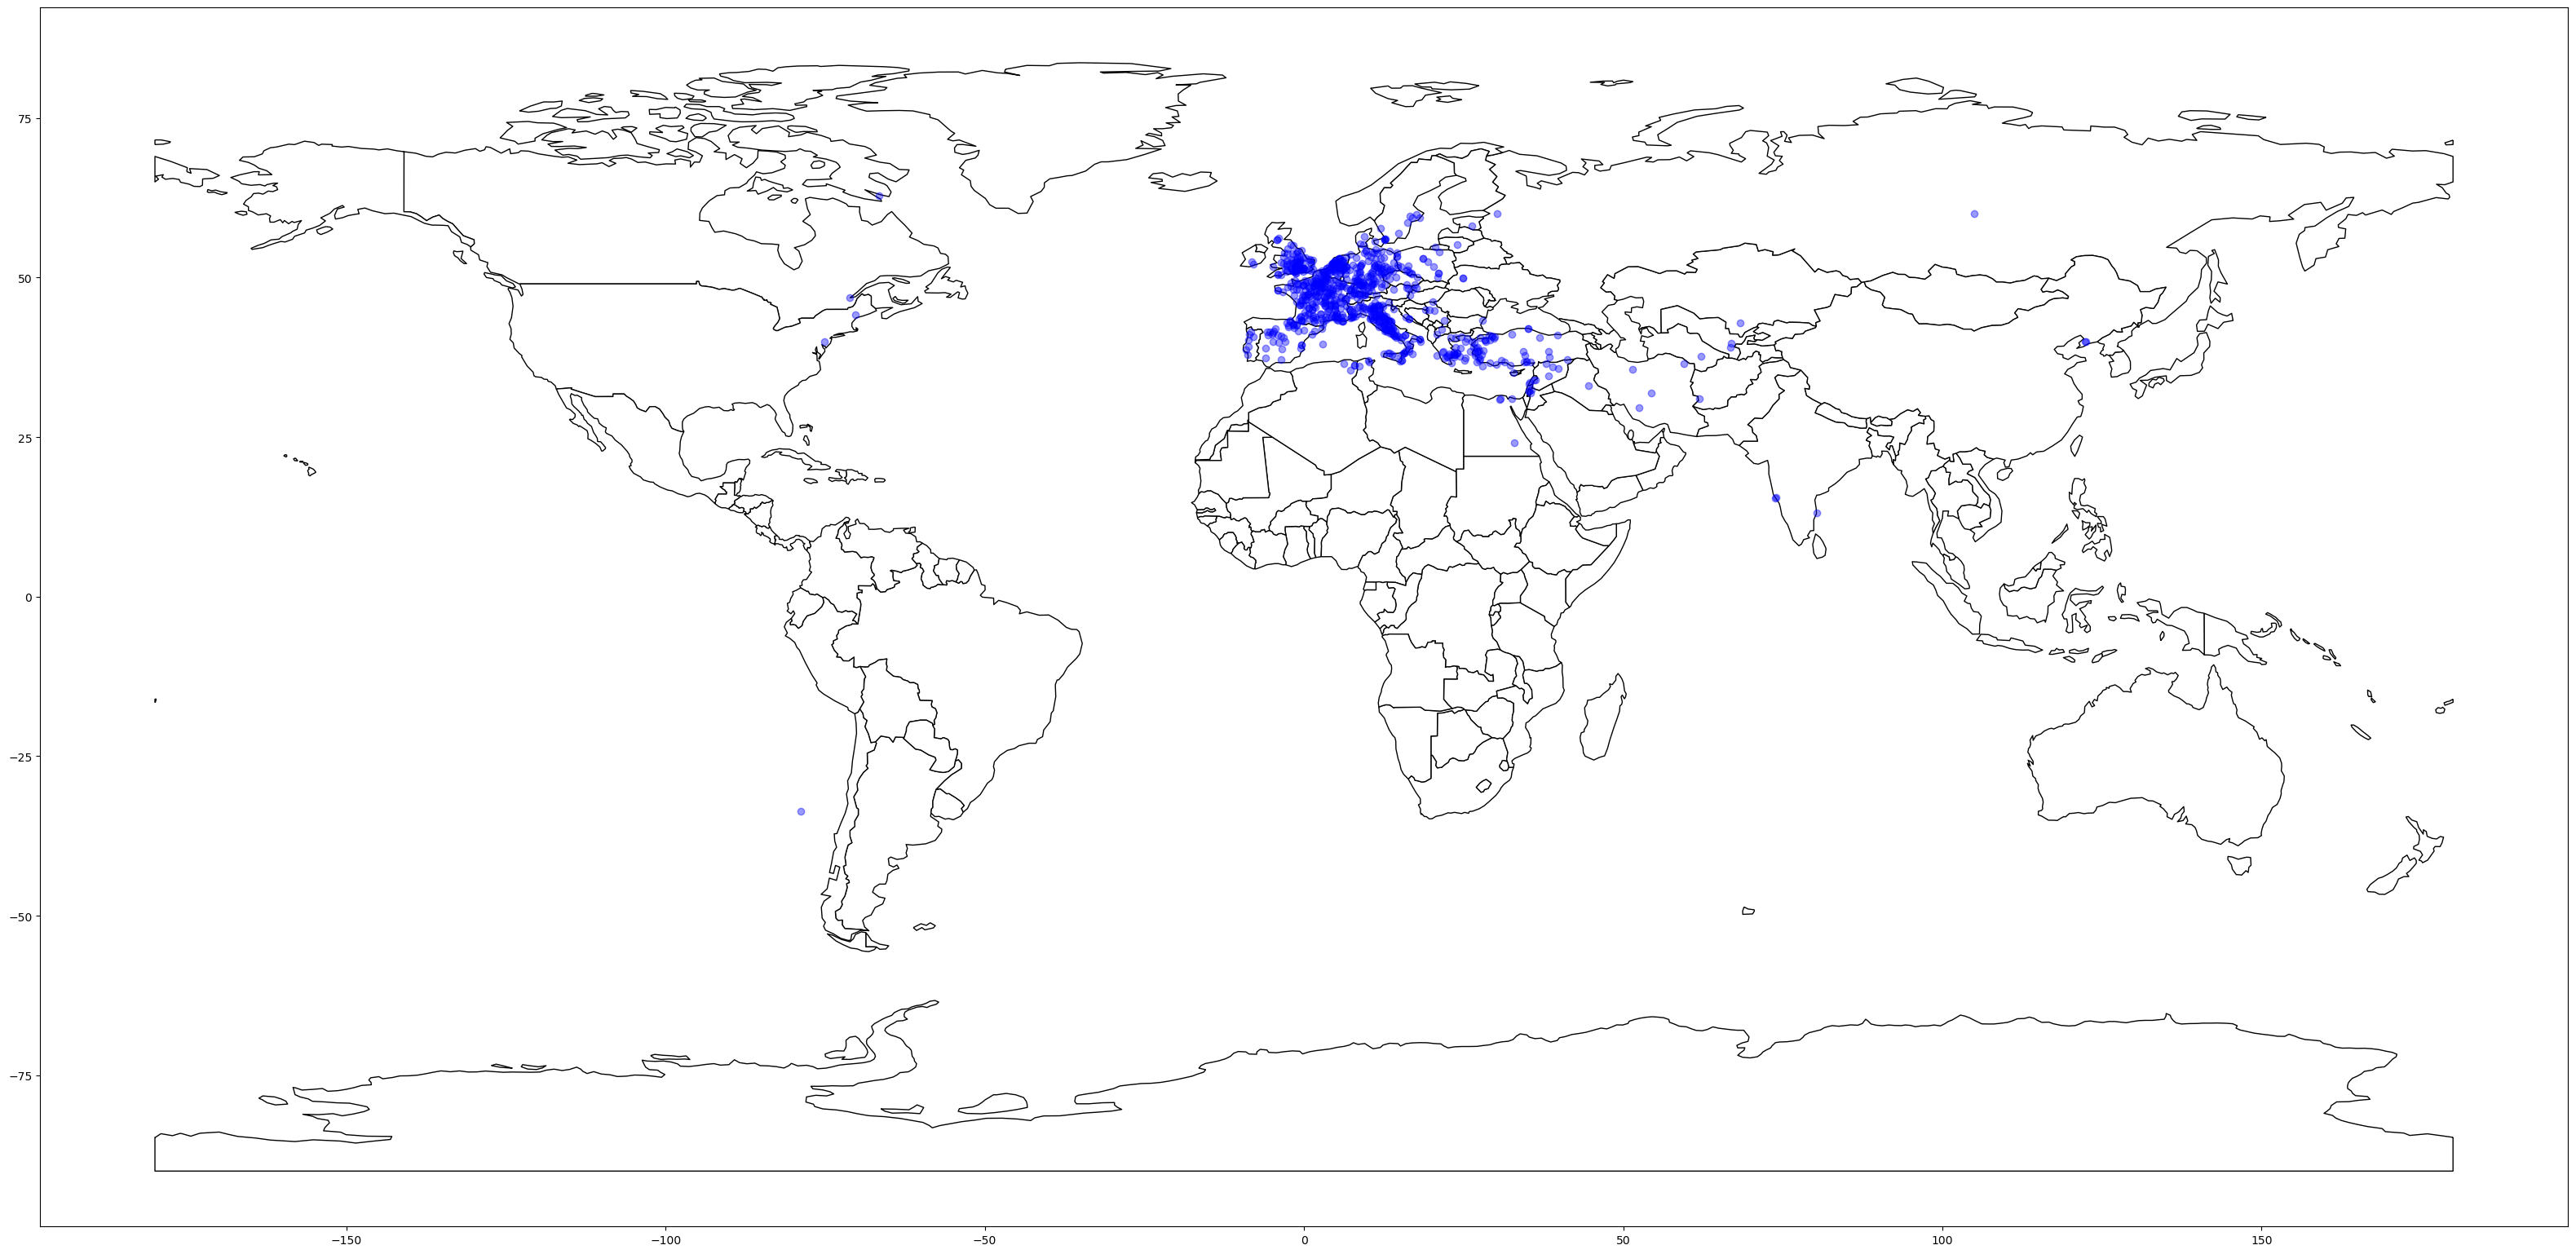

In [82]:
import matplotlib.pyplot as plt
ax = world.plot(
    color='white', edgecolor='black', figsize=(40, 60))
gdf.plot(ax=ax, color='blue', alpha=0.4)
plt.savefig('villes', bbox_inches='tight')
plt.show()

## Extraction de plus d'informations sur les êtres humains

In [83]:
def cree_requete_humain(cand):
    query = '''
    SELECT ?type ?dn ?dd ?libellé_fr ?desc_fr ?libellé_en ?desc_en ?ln ?ld ?occupations
    WHERE 
    {{
        OPTIONAL {{
            wd:{0}  wdt:P31 ?type .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_fr filter (lang(?libellé_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} rdfs:label ?libellé_en filter (lang(?libellé_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_fr filter (lang(?desc_fr) = "fr") .
        }}
        OPTIONAL {{
            wd:{0} schema:description ?desc_en filter (lang(?desc_en) = "en") .
        }}
        OPTIONAL {{
            wd:{0} wdt:P569 ?dn .
        }}
        OPTIONAL {{
            wd:{0} wdt:P570 ?dd .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P19 ?ln .
        }}
        OPTIONAL {{
            wd:{0}  wdt:P20 ?ld .
        }}
        OPTIONAL {{
            wd:{0}  p:P106 ?occupation .
            ?occupation ps:P106 ?occupations .
        }}
    
    }}'''.format(cand)
    return query

In [84]:
a = cree_requete_humain('Q14279')

In [85]:
b = applique_requete(a, prefixes, headers)
b

[{'occupations': {'type': 'uri',
   'value': 'http://www.wikidata.org/entity/Q155647'},
  'desc_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Italian/French mathematician, astronomer, engineer, and astrologer (*1625 – †1712)'},
  'desc_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'astronome et ingénieur, naturalisé français'},
  'libellé_en': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Giovanni Domenico Cassini'},
  'libellé_fr': {'xml:lang': 'fr',
   'type': 'literal',
   'value': 'Jean-Dominique Cassini'},
  'type': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q5'},
  'dn': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1625-06-08T00:00:00Z'},
  'dd': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
   'type': 'literal',
   'value': '1712-09-14T00:00:00Z'},
  'ln': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q269476'},
  'ld': {'type': 'uri', 'value': 'http://www.wikida

In [86]:
condense_dict(b[1])

{'occupations': 'http://www.wikidata.org/entity/Q81096',
 'desc_en': 'Italian/French mathematician, astronomer, engineer, and astrologer (*1625 – †1712)',
 'desc_fr': 'astronome et ingénieur, naturalisé français',
 'libellé_en': 'Giovanni Domenico Cassini',
 'libellé_fr': 'Jean-Dominique Cassini',
 'type': 'http://www.wikidata.org/entity/Q5',
 'dn': '1625-06-08T00:00:00Z',
 'dd': '1712-09-14T00:00:00Z',
 'ln': 'http://www.wikidata.org/entity/Q269476',
 'ld': 'http://www.wikidata.org/entity/Q90'}

In [87]:
lieux_humains[:10]

[['Q213288', ['Q3159182', 'Q1113964']],
 ['Q154728', ['Q71132072', 'Q3174233', 'Q1579772', 'Q644057']],
 ['Q209810', ['Q3158256']],
 ['Q898563', ['Q793631']],
 ['Q207371', ['Q206384', 'Q471406']],
 ['Q820042', ['Q698691']],
 ['Q155981', ['Q1078925']],
 ['Q6381', ['Q116432615', 'Q1496335', 'Q290227']],
 ['Q456',
  ['Q1410935',
   'Q1320032',
   'Q687932',
   'Q605799',
   'Q2273795',
   'Q15504853',
   'Q1411',
   'Q2977512',
   'Q17516066',
   'Q3084673',
   'Q505134',
   'Q302936',
   'Q375783',
   'Q3160158']],
 ['Q8471', ['Q954134']]]

In [88]:
len(lieux_humains), sum(map(lambda x: len(x[1]), lieux_humains))

(827, 1712)

In [89]:
details_lieux_humains = []
for lieu_humains in tqdm(lieux_humains):
    while True:
        dicos_humains = {}
        temp_lieu_humains = []
        for humain in lieu_humains[1]:
            time.sleep(2)
            qt = cree_requete_humain(humain)
            dic_l = applique_requete(qt, prefixes, headers)
            if dic_l == ['échec']:
                break
            dicos_humains[humain] = fusionne_dicts_wd(dic_l)
        if dic_l != ['échec']:
            break
    details_lieux_humains += [(lieu_humains[0], dicos_humains)]

100%|██████████| 827/827 [1:07:19<00:00,  4.89s/it]


In [90]:
lieux_humains[:5]

[['Q213288', ['Q3159182', 'Q1113964']],
 ['Q154728', ['Q71132072', 'Q3174233', 'Q1579772', 'Q644057']],
 ['Q209810', ['Q3158256']],
 ['Q898563', ['Q793631']],
 ['Q207371', ['Q206384', 'Q471406']]]

In [91]:
details_lieux_humains[:7]

[('Q213288',
  {'Q3159182': {'occupations': ['Q1234713', 'Q250867'],
    'libellé_en': ['Jacques Joseph Duguet'],
    'libellé_fr': ['Jacques Joseph Duguet'],
    'type': ['Q5'],
    'dn': ['1649-12-04T00:00:00Z'],
    'dd': ['1733-10-25T00:00:00Z'],
    'ln': ['Q213288'],
    'ld': ['Q90']},
   'Q1113964': {'occupations': ['Q10429346', 'Q333634', 'Q6673651'],
    'desc_en': ['French politician'],
    'desc_fr': ['écrivain français'],
    'libellé_en': ['Antoine du Verdier'],
    'libellé_fr': ['Antoine du Verdier'],
    'type': ['Q5'],
    'dn': ['1544-11-21T00:00:00Z'],
    'dd': ['1600-09-25T00:00:00Z'],
    'ln': ['Q213288'],
    'ld': ['Q1469399']}}),
 ('Q154728',
  {'Q71132072': {'occupations': ['Q201788', 'Q250867'],
    'desc_en': ['historian and Capuchin priest'],
    'desc_fr': ["érudit et historien lorrain, de l'ordre des Capucins"],
    'libellé_en': ['Benoît Picart'],
    'libellé_fr': ['Benoît Picart'],
    'type': ['Q5'],
    'dn': ['1660-01-01T00:00:00Z'],
    'dd': ['1

In [92]:
lieux_humains[2]

['Q209810', ['Q3158256']]

In [93]:
details_lieux_humains[1]

('Q154728',
 {'Q71132072': {'occupations': ['Q201788', 'Q250867'],
   'desc_en': ['historian and Capuchin priest'],
   'desc_fr': ["érudit et historien lorrain, de l'ordre des Capucins"],
   'libellé_en': ['Benoît Picart'],
   'libellé_fr': ['Benoît Picart'],
   'type': ['Q5'],
   'dn': ['1660-01-01T00:00:00Z'],
   'dd': ['1720-01-01T00:00:00Z']},
  'Q3174233': {'occupations': ['Q1234713'],
   'desc_fr': ['théologien (1443-1514)'],
   'libellé_en': ['Jean Raulin'],
   'libellé_fr': ['Jean Raulin'],
   'type': ['Q5'],
   'dn': ['1443-01-01T00:00:00Z'],
   'dd': ['1514-01-01T00:00:00Z'],
   'ln': ['Q154728']},
  'Q1579772': {'occupations': ['Q1234713', 'Q201788'],
   'desc_en': ['Jesuit theologian'],
   'desc_fr': ['jésuite lorrain, professeur de rhétorique et de théologie'],
   'libellé_en': ['Nicholas Abram'],
   'libellé_fr': ['Nicolas Abram'],
   'type': ['Q5'],
   'dn': ['1589-01-01T00:00:00Z'],
   'dd': ['1657-01-01T00:00:00Z',
    '1655-12-07T00:00:00Z',
    '1655-09-07T00:00:00Z'

In [94]:
details_lieux_humains[2]

('Q209810',
 {'Q3158256': {'occupations': ['Q1622272', 'Q1234713', 'Q201788'],
   'desc_en': ['French theologian'],
   'desc_fr': ["professeur d'université"],
   'libellé_en': ['Jacques Bernard'],
   'libellé_fr': ['Jacques Bernard'],
   'type': ['Q5'],
   'dn': ['1658-09-01T00:00:00Z'],
   'dd': ['1718-04-27T00:00:00Z']}})

In [95]:
len(details_lieux_humains[2][1].keys())

1

In [96]:
len(details_lieux_humains), sum(map(lambda x: len(x[1].keys()), details_lieux_humains))

(827, 1712)

In [97]:
with open('lieux_humains_details.json', 'w') as f:
    json.dump(details_lieux_humains, f)